## Tutorial 07 - Non linear Elliptic problem
**_Keywords: DEIM, POD-Galerkin_**

### 1. Introduction

In this tutorial, we consider a non linear elliptic problem in a two-dimensional spatial domain $\Omega=(0,1)^2$. We impose a homogeneous Dirichlet condition on the boundary $\partial\Omega$. The source term is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = 100\sin(2\pi x_0)cos(2\pi x_1) \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

This problem is characterized by two parameters. The first parameter $\mu_0$ controls the strength of the sink term and the second parameter $\mu_1$ the strength of the nonlinearity. The range of the two parameters is the following:
$$
\mu_0,\mu_1\in[0.01,10.0]
$$
The parameter vector $\boldsymbol{\mu}$ is thus given by
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.01,10]^2.
$$


In order to obtain a faster approximation of the problem, we pursue a model reduction by means of a POD-Galerkin reduced order method. In order to preserve the affinity assumption the discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$.



### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the solution in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$ -\nabla^2u(\boldsymbol{\mu})+\frac{\mu_0}{\mu_1}(\exp\{\mu_1u(\boldsymbol{\mu})\}-1)=g(\boldsymbol{x}; \boldsymbol{\mu})$$
<br>
    
The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)+c\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H_1(\Omega) : v|_{\partial\Omega}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized bilinear form $c(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$c(u, v;\boldsymbol{\mu})=\mu_0\int_{\Omega} \frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \int_{\Omega}g(\boldsymbol{x}; \boldsymbol{\mu})v \ d\boldsymbol{x}.$$

The output of interest $s(\boldsymbol{\mu})$ is given by
$$s(\boldsymbol{\mu}) = \int_{\Omega} v \ d\boldsymbol{x}$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

### 3. Affine Decomposition 

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{1}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)},$$
$$c(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{c}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x}}_{c_0(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{100}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Omega}\sin(2\pi x_0)cos(2\pi x_1)v \ d\boldsymbol{x}}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class NonlinearElliptic(NonlinearEllipticProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$, $\Theta^{c}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):
```
and the bilinear forms $a_*(u, v)$, $c_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
@DEIM("online", basis_generation="Greedy")
@ExactParametrizedFunctions("offline")
class NonlinearElliptic(NonlinearEllipticProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NonlinearEllipticProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.du = TrialFunction(V)
        self.u = self._solution
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Store the forcing term expression
        self.f = Expression("sin(2*pi*x[0])*sin(2*pi*x[1])", element=self.V.ufl_element())
        # Customize nonlinear solver parameters
        self._nonlinear_solver_parameters.update({
            "linear_solver": "mumps",
            "maximum_iterations": 20,
            "report": True
        })

    # Return custom problem name
    def name(self):
        return "NonlinearEllipticDEIM"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.
            return (theta_a0,)
        elif term == "c":
            theta_c0 = mu[0]
            return (theta_c0,)
        elif term == "f":
            theta_f0 = 100.
            return (theta_f0,)
        elif term == "s":
            theta_s0 = 1.0
            return (theta_s0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            du = self.du
            a0 = inner(grad(du), grad(v)) * dx
            return (a0,)
        elif term == "c":
            u = self.u
            mu = self.mu
            c0 = (exp(mu[1] * u) - 1) / mu[1] * v * dx
            return (c0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "s":
            s0 = v * dx
            return (s0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1)]
            return (bc0,)
        elif term == "inner_product":
            du = self.du
            x0 = inner(grad(du), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NonlinearEllipticProblem)
def CustomizeReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
    class ReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNonlinearElliptic_Base.__init__(self, truth_problem, **kwargs)
            self._nonlinear_solver_parameters.update({
                "report": True,
                "line_search": "wolfe"
            })

    return ReducedNonlinearElliptic

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/square.xml")
subdomains = MeshFunction("size_t", mesh, "data/square_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/square_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the NonlinearElliptic class

In [5]:
problem = NonlinearElliptic(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.01, 10.0), (0.01, 10.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20, DEIM=21)
reduction_method.set_tolerance(1e-8, DEIM=1e-4)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(50, DEIM=60)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train PINN

Given a training set $X_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(n)})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(X_{PINN}; W) = \frac1n \sum_{i=1}^n \left\|A(\boldsymbol{\mu^{(i)}}) \operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)}) + \boldsymbol{c}(\boldsymbol{\mu}^{(i)})\right\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the bilinear form $a$, $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the linear form $f$, and $\boldsymbol{c}(\boldsymbol{\mu})$ is a vector corresponding to the nonlinear form $c$.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer,
    input_normalization_pinn, num_epochs=1000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [20]:
pinn_trainer.train()

Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 's' not implemented. Continuing without operator 's'...
13000 1.719937323965695e-05 	Loss(validation) = 0.0015733815977661398
13100 1.2705637153913424e-05 	Loss(validation) = 0.0015174512164064635
13200 0.00015405084840403927 	Loss(validation) = 0.0016483525045297414
13300 3.5444324035896905e-05 	Loss(validation) = 0.0015362823497308534
13400 7.644702771468974e-05 	Loss(validation) = 0.0017310077287203067
13500 0.0001739830736513532 	Loss(validation) = 0.001633199652475683
13600 4.3709759767678626e-05 	Loss(validation) = 0.001440448854669446
13700 5.45734685918828e-05 	Loss(validation) = 0.0015206194029470446
13800 0.00035790706254543723 	Loss(validation) = 0.002083748446915889
13900 1.1235617088622334e-05 	Loss(validation) = 0.0014678711431716396


In [ ]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $X_{PDNN} = ((\boldsymbol{\mu}^{(1)}, \operatorname{HF}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(n)}, \operatorname{HF}(\boldsymbol{\mu}^{(n)})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(X_{PDNN}; W) = \frac1n \sum_{i=1}^n \|\operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \tilde{\operatorname{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, $\tilde{\operatorname{HF}}(\boldsymbol{\mu})$ is the projection of $\operatorname{HF}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [ ]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [ ]:
pdnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependnent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(X_{PINN}, X_{PDNN}; W) = L_{PINN}(X_{PINN}; W) + \omega L_{PDNN}(X_{PDNN}; W),$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [ ]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer,
    input_normalization_prnn, num_epochs=1000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [ ]:
prnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [21]:
reduction_method.initialize_testing_set(50, DEIM=60)
reduction_method.error_analysis()

=                        DEIM error analysis begins for                        =
=   { v_0 * (-1 + exp(f_9 * f_14)) / f_14 } * dx(<Mesh #0>[everywhere], {}),   =
=                                    where                                     =
=                                 f_14 = mu_1                                  =
=f_9 = solution of NonlinearEllipticDEIM (exact problem decorator: False, component: (None,))=
=               with id 49fc90be369b6ead57691b159f98bb7ecf8d1031               =

:::::::::::::::::::::::::::::::::::: DEIM 0 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 1 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 2 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 3 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 4 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 5 ::::::::::::::::::::::::::::::::::::
:::::::::::::

:::::::::::::::::::::::::::::::::::: DEIM 4 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 5 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 6 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 7 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 8 ::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::::::::::::::: DEIM 9 ::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::: DEIM 10 ::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::: DEIM 11 ::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::: DEIM 12 ::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::: DEIM 13 ::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::: DEIM 14 ::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::: DEIM 15 ::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::

1:  |F(x)| = 2.94048; step 0.201859
2:  |F(x)| = 1.17722; step 1
3:  |F(x)| = 0.182188; step 1
4:  |F(x)| = 0.00585409; step 1
5:  |F(x)| = 5.54299e-05; step 1
6:  |F(x)| = 1.26439e-06; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.71229; step 0.315778
1:  |F(x)| = 2.94078; step 0.201786
2:  |F(x)| = 1.17772; step 1
3:  |F(x)| = 0.182519; step 1
4:  |F(x)| = 0.00585162; step 1
5:  |F(x)| = 6.27861e-05; step 1
6:  |F(x)| = 1.01304e-06; step 1
scipy solver converged in 8 iterations.
###################################### 1 #######################################
0:  |F(x)| = 1.28417; step 1
1:  |F(x)| = 0.146203; step 1
2:  |F(x)| = 0.0021594; step 1
3:  |F(x)| = 3.92691e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 3.14394; step 0.413952
1:  |F(x)| = 0.96312; step 1
2:  |F(x)| = 0.127978; step 1
3:  |F(x)| = 0.00317339; step 1
4:  |F(x)| = 3.14583e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.14551; step 0.413706
1:  |F(x)| = 0.970

0:  |F(x)| = 1.33931; step 1
1:  |F(x)| = 0.152489; step 1
2:  |F(x)| = 0.00225112; step 1
3:  |F(x)| = 6.43077e-08; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 3.16666; step 0.40877
1:  |F(x)| = 0.901885; step 1
2:  |F(x)| = 0.10755; step 1
3:  |F(x)| = 0.00216532; step 1
4:  |F(x)| = 2.11082e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.16773; step 0.408605
1:  |F(x)| = 0.910214; step 1
2:  |F(x)| = 0.108934; step 1
3:  |F(x)| = 0.00207496; step 1
4:  |F(x)| = 4.95212e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.17652; step 0.407187
1:  |F(x)| = 0.930032; step 1
2:  |F(x)| = 0.110734; step 1
3:  |F(x)| = 0.00208335; step 1
4:  |F(x)| = 5.34024e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.1757; step 0.407318
1:  |F(x)| = 0.925575; step 1
2:  |F(x)| = 0.109343; step 1
3:  |F(x)| = 0.0020399; step 1
4:  |F(x)| = 4.14934e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.17572; step 0.407315


5:  |F(x)| = 3.55031e-05; step 1
6:  |F(x)| = 2.06443e-06; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.65159; step 0.313074
1:  |F(x)| = 2.46389; step 0.30903
2:  |F(x)| = 0.452721; step 1
3:  |F(x)| = 0.0318685; step 1
4:  |F(x)| = 0.000405336; step 1
5:  |F(x)| = 3.60799e-05; step 1
6:  |F(x)| = 1.96053e-06; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.65153; step 0.313082
1:  |F(x)| = 2.4642; step 0.308935
2:  |F(x)| = 0.453659; step 1
3:  |F(x)| = 0.0312071; step 1
4:  |F(x)| = 0.000386378; step 1
5:  |F(x)| = 3.31816e-05; step 1
6:  |F(x)| = 1.8119e-06; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.65152; step 0.313083
1:  |F(x)| = 2.4647; step 0.308825
2:  |F(x)| = 0.453294; step 1
3:  |F(x)| = 0.0314442; step 1
4:  |F(x)| = 0.000340288; step 1
5:  |F(x)| = 3.56293e-05; step 1
6:  |F(x)| = 1.0924e-06; step 1
scipy solver converged in 8 iterations.
###################################### 10 ######################################
0:

3:  |F(x)| = 0.065009; step 1
4:  |F(x)| = 0.000656839; step 1
5:  |F(x)| = 6.7867e-05; step 1
6:  |F(x)| = 3.86295e-06; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.72465; step 0.316845
1:  |F(x)| = 2.34983; step 0.333423
2:  |F(x)| = 0.601428; step 1
3:  |F(x)| = 0.0650887; step 1
4:  |F(x)| = 0.000659177; step 1
5:  |F(x)| = 6.62104e-05; step 1
6:  |F(x)| = 3.67833e-06; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.72464; step 0.316847
1:  |F(x)| = 2.35; step 0.333388
2:  |F(x)| = 0.601111; step 1
3:  |F(x)| = 0.065137; step 1
4:  |F(x)| = 0.000605266; step 1
5:  |F(x)| = 6.32228e-05; step 1
6:  |F(x)| = 1.87562e-06; step 1
scipy solver converged in 8 iterations.
###################################### 14 ######################################
0:  |F(x)| = 0.406285; step 1
1:  |F(x)| = 0.0101437; step 1
2:  |F(x)| = 4.92085e-06; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 3.5384; step 0.355108
1:  |F(x)| = 1.00771; step 1
2:  |F(x)| = 

1:  |F(x)| = 1.41281; step 0.479101
2:  |F(x)| = 0.287278; step 1
3:  |F(x)| = 0.00937951; step 1
4:  |F(x)| = 1.25563e-05; step 1
5:  |F(x)| = 2.90451e-09; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.57304; step 0.341404
1:  |F(x)| = 2.14027; step 0.380905
2:  |F(x)| = 0.301708; step 1
3:  |F(x)| = 0.0165766; step 1
4:  |F(x)| = 6.41811e-05; step 1
5:  |F(x)| = 4.03939e-08; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.57407; step 0.341238
1:  |F(x)| = 2.15893; step 0.376383
2:  |F(x)| = 0.312004; step 1
3:  |F(x)| = 0.0176384; step 1
4:  |F(x)| = 4.57207e-05; step 1
5:  |F(x)| = 3.47059e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.57699; step 0.340729
1:  |F(x)| = 2.18041; step 0.371418
2:  |F(x)| = 0.326884; step 1
3:  |F(x)| = 0.0179608; step 1
4:  |F(x)| = 5.7332e-05; step 1
5:  |F(x)| = 3.82962e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.5767; step 0.340775
1:  |F(x)| = 2.17723; step 0.372169
2:  |F(x)

4:  |F(x)| = 0.000556236; step 1
5:  |F(x)| = 1.53178e-05; step 1
6:  |F(x)| = 3.91726e-07; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.68995; step 0.319675
1:  |F(x)| = 2.62324; step 0.278111
2:  |F(x)| = 0.665136; step 1
3:  |F(x)| = 0.066575; step 1
4:  |F(x)| = 0.000513232; step 1
5:  |F(x)| = 1.65545e-05; step 1
6:  |F(x)| = 4.13752e-07; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.68997; step 0.319672
1:  |F(x)| = 2.6237; step 0.277998
2:  |F(x)| = 0.665835; step 1
3:  |F(x)| = 0.0664018; step 1
4:  |F(x)| = 0.00052643; step 1
5:  |F(x)| = 1.5378e-05; step 1
6:  |F(x)| = 3.60126e-07; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.68998; step 0.319671
1:  |F(x)| = 2.62395; step 0.277942
2:  |F(x)| = 0.665983; step 1
3:  |F(x)| = 0.0665805; step 1
4:  |F(x)| = 0.000505293; step 1
5:  |F(x)| = 1.7811e-05; step 1
6:  |F(x)| = 1.86963e-07; step 1
scipy solver converged in 8 iterations.
###################################### 23 ########

0:  |F(x)| = 0.0583746; step 1
1:  |F(x)| = 0.000225868; step 1
2:  |F(x)| = 6.32067e-07; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 1.01958; step 1
1:  |F(x)| = 0.0858837; step 1
2:  |F(x)| = 0.000668331; step 1
3:  |F(x)| = 7.53526e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 1.01918; step 1
1:  |F(x)| = 0.0856623; step 1
2:  |F(x)| = 0.000603308; step 1
3:  |F(x)| = 1.83653e-06; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 1.02192; step 1
1:  |F(x)| = 0.0880211; step 1
2:  |F(x)| = 0.000733582; step 1
3:  |F(x)| = 1.26503e-06; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 1.02184; step 1
1:  |F(x)| = 0.0879304; step 1
2:  |F(x)| = 0.000719103; step 1
3:  |F(x)| = 2.34961e-06; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 1.02187; step 1
1:  |F(x)| = 0.0878567; step 1
2:  |F(x)| = 0.000727514; step 1
3:  |F(x)| = 2.91771e-06; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 1.02189; step 1
1:  

0:  |F(x)| = 0.304557; step 1
1:  |F(x)| = 0.00243594; step 1
2:  |F(x)| = 1.42617e-05; step 1
3:  |F(x)| = 1.4866e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.304483; step 1
1:  |F(x)| = 0.00270829; step 1
2:  |F(x)| = 1.53243e-05; step 1
3:  |F(x)| = 1.98831e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.305113; step 1
1:  |F(x)| = 0.00268988; step 1
2:  |F(x)| = 1.24576e-05; step 1
3:  |F(x)| = 1.76509e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.305141; step 1
1:  |F(x)| = 0.00267583; step 1
2:  |F(x)| = 1.74269e-05; step 1
3:  |F(x)| = 3.0797e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.305149; step 1
1:  |F(x)| = 0.00262898; step 1
2:  |F(x)| = 1.42817e-05; step 1
3:  |F(x)| = 2.99479e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.305156; step 1
1:  |F(x)| = 0.00261051; step 1
2:  |F(x)| = 1.46869e-05; step 1
3:  |F(x)| = 3.02736e-07; step 1
scipy solver converged in 5 iterat

1:  |F(x)| = 0.000493135; step 1
2:  |F(x)| = 2.15245e-06; step 1
scipy solver converged in 4 iterations.
###################################### 40 ######################################
0:  |F(x)| = 0.277315; step 1
1:  |F(x)| = 0.00393174; step 1
2:  |F(x)| = 2.80879e-07; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 2.58059; step 0.52144
1:  |F(x)| = 0.369802; step 1
2:  |F(x)| = 0.0222926; step 1
3:  |F(x)| = 8.48713e-05; step 1
4:  |F(x)| = 2.75065e-08; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 2.5803; step 0.521487
1:  |F(x)| = 0.370612; step 1
2:  |F(x)| = 0.0224005; step 1
3:  |F(x)| = 6.27145e-05; step 1
4:  |F(x)| = 3.0765e-07; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 2.60568; step 0.517178
1:  |F(x)| = 0.380939; step 1
2:  |F(x)| = 0.0233715; step 1
3:  |F(x)| = 8.31579e-05; step 1
4:  |F(x)| = 9.54209e-08; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 2.60486; step 0.517315
1:  |F(x)| = 0.380869; step 1
2:  |F

scipy solver converged in 9 iterations.
0:  |F(x)| = 3.63954; step 0.314982
1:  |F(x)| = 2.73139; step 0.238875
2:  |F(x)| = 0.776464; step 1
3:  |F(x)| = 0.0875217; step 1
4:  |F(x)| = 0.000944452; step 1
5:  |F(x)| = 0.000110888; step 1
6:  |F(x)| = 4.21503e-06; step 1
scipy solver converged in 8 iterations.
###################################### 45 ######################################
0:  |F(x)| = 2.91671; step 0.46413
1:  |F(x)| = 1.32661; step 0.490663
2:  |F(x)| = 0.270558; step 1
3:  |F(x)| = 0.00919044; step 1
4:  |F(x)| = 1.53138e-05; step 1
5:  |F(x)| = 7.32383e-09; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.58409; step 0.342345
1:  |F(x)| = 2.76934; step 0.220576
2:  |F(x)| = 1.05922; step 1
3:  |F(x)| = 0.167873; step 1
4:  |F(x)| = 0.00604942; step 1
5:  |F(x)| = 7.74813e-06; step 1
6:  |F(x)| = 9.98507e-10; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.58564; step 0.342089
1:  |F(x)| = 2.781; step 0.217849
2:  |F(x)| = 1.07314; step 1



=            NonlinearEllipticDEIM POD-Galerkin error analysis ends            =



#### 4.6.2 PINN Error Analysis

In [22]:
test_mu = torch.tensor(reduction_method.testing_set)

In [23]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn, relative=False
)

  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.358795e+00
  2 SNES Function norm 1.221066e+00
  3 SNES Function norm 1.096610e+00
  4 SNES Function norm 8.711714e-01
  5 SNES Function norm 6.783414e-01
  6 SNES Function norm 1.549965e-01
  7 SNES Function norm 1.318824e-02
  8 SNES Function norm 1.104893e-04
  9 SNES Function norm 7.775040e-09
  10 SNES Function norm 4.163281e-15
PETSc SNES solver converged in 10 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.210376e+00
  2 SNES Function norm 6.348453e-01
  3 SNES Function norm 1.129758e-01
  4 SNES Function norm 7.508284e-03
  5 SNES Function norm 3.564959e-05
  6 SNES Function norm 7.890209e-10
PETSc SNES solver converged in 6 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.359049e+00
  2 SNES Function norm 1.221861e+00
  3 SNES Function norm 1.010598e+00
  4 SNES Function norm 5.332263e-01
  5 SNES Function norm 8.233

  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.385956e-02
  2 SNES Function norm 6.974965e-05
  3 SNES Function norm 5.593886e-10
PETSc SNES solver converged in 3 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.358771e+00
  2 SNES Function norm 1.221097e+00
  3 SNES Function norm 1.055061e+00
  4 SNES Function norm 6.491055e-01
  5 SNES Function norm 1.636693e-01
  6 SNES Function norm 1.491468e-02
  7 SNES Function norm 1.435767e-04
  8 SNES Function norm 1.313030e-08
  9 SNES Function norm 4.124473e-15
PETSc SNES solver converged in 9 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.937582e-02
  2 SNES Function norm 8.354075e-05
  3 SNES Function norm 8.335566e-10
PETSc SNES solver converged in 3 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.763350e-01
  2 SNES Function norm 6.612218e-02
  3 SNES Function norm 2.316261

  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.440650e-03
  2 SNES Function norm 6.241871e-08
  3 SNES Function norm 3.890458e-15
PETSc SNES solver converged in 3 iterations with convergence reason 2.
#################################### N = 8 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0009743638567696707	0.0011027412840119376	0.00015712905092398407
mean	0.007800978130927627	0.007800150152094154	0.00038191949041505306
max	0.13836931091106314	0.13840250778180807	0.0008181717739602567


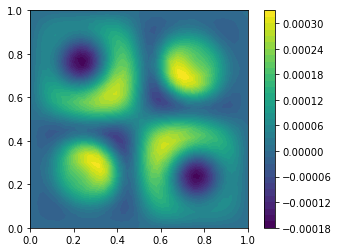

In [25]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (5., 5.), input_normalization_pinn, output_normalization_pinn, colorbar=True
)

#### 4.6.3 PDNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn, relative=False
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (5., 5.), input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn, relative=False
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (5., 5.), input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [ ]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, relative=False
)

### 4.7. Perform a speedup analysis

In [ ]:
reduction_method.speedup_analysis()